In [258]:
import os

import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [259]:
prefixes = ['bitonic_1to14', 'simple_10to17']

In [260]:
main_dfs = []
for prefix in prefixes:
    curr_df = pd.read_csv(os.path.join(prefix, 'table.csv'), index_col=0)
    curr_df['prefix'] = prefix.split('_')[0]
    main_dfs.append(curr_df)
df_main = pd.concat(main_dfs, axis=0, ignore_index=True).reset_index()

df_main

,index,name,syncs,max_syncs,reads,writes,промахи ср,промахи ди,исп кэша ср,исп кэша ди,промахи L2 ср,промахи L2 ди,исп L2 ср,исп L2 ди,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean,nprs_ci,prefix
0,0,1_stock_1,[0],0,[4],[2],106831.090,2968.362582,7.071780e+07,9.949107e+05,1.520853e+07,2.101223e+05,1.943678e+08,8.949622e+05,0.001515,0.078255,1720.622450,21.480473,bitonic
1,1,1_depth_1,[2],2,[4],[4],69309.835,19003.623340,4.628529e+07,8.611873e+05,9.928484e+06,2.088603e+05,1.256131e+08,7.191426e+05,0.001492,0.079003,1729.872900,18.357394,bitonic
2,2,2_depth_1,"[2, 2]",2,"[2, 2]","[2, 2]",50293.440,3587.464041,6.253622e+07,9.786136e+05,1.471499e+07,2.838085e+05,1.344575e+08,1.173499e+06,0.000810,0.109536,2137.332450,34.104764,bitonic
3,3,4_depth_1,"[2, 2, 2, 2]",2,"[2, 0, 2, 0]","[2, 0, 2, 0]",57983.925,3781.825229,1.089544e+08,1.354156e+06,2.717079e+07,4.550935e+05,1.784707e+08,1.989107e+06,0.000535,0.152338,2979.134950,17.039658,bitonic
4,4,1_stock_2,[0],0,[24],[12],47177.960,2237.579120,6.400682e+07,1.030954e+06,1.380812e+07,2.322587e+05,1.764090e+08,1.007128e+06,0.000740,0.078277,285.956720,3.293340,bitonic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,1_depth_4096,[21],21,[163840],[86016],148524.470,7252.372243,1.244556e+09,2.043239e+07,5.989829e+08,1.076757e+07,7.226439e+08,1.263595e+07,0.000120,0.828761,0.367013,0.007559,simple
100,100,2_stock_4096,"[2, 2]",2,"[81920, 81920]","[43008, 43008]",167259.440,40302.188408,1.854247e+09,1.952842e+07,8.742294e+08,9.447547e+06,1.008478e+09,1.088861e+07,0.000090,0.866879,0.248327,0.002979,simple
101,101,2_depth_4096,"[21, 21]",21,"[81920, 81920]","[43008, 43008]",141729.965,5350.002836,1.745212e+09,1.167543e+07,6.297719e+08,4.480244e+06,7.977248e+08,5.104023e+06,0.000081,0.789413,0.509783,0.002764,simple
102,102,4_stock_4096,"[2, 2, 2, 2]",2,"[40960, 40960, 40960, 40960]","[21504, 21504, 21504, 21504]",217859.025,68382.158328,2.385095e+09,3.692474e+07,1.116101e+09,1.769636e+07,1.300283e+09,2.066193e+07,0.000092,0.858361,0.180111,0.002988,simple


In [261]:
df = df_main.copy()

df['mean_cache_misses_to_mean_cache_refs'] = df['промахи ср'] / df['исп кэша ср']
df['mean_L2_misses_to_mean_L2_refs'] = df['промахи L2 ср'] / df['исп L2 ср']
df['threads'] = df['reads'].apply(lambda x: len(eval(x)))
df['threads_inverse'] = 1. / df['threads']
df['reads'] = df['reads'].apply(lambda x: sum(eval(x)))
df['writes'] = df['writes'].apply(lambda x: sum(eval(x)))
df['reads_ratio'] = df['reads'] / (df['reads'] + df['writes'])
df['operations'] = df['reads'] + df['writes']
df['algo'] = df['name'].str.split('_', expand=True).loc[:, 1]
df['graph_width'] = df['name'].str.split('_', expand=True).loc[:, 2]
df['graph_type'] = df['prefix']
df['nprs_mean_weighted'] = df['nprs_mean'] * df['threads']
df['log_nprs_mean_weighted'] = np.log(df['nprs_mean_weighted'])
df['total_syncs'] = df['syncs'].apply(lambda x: sum(eval(x)))
df['mean_syncs'] = df['syncs'].apply(lambda x: np.mean(eval(x)))

In [262]:
X_keys = ['operations', 'threads', 'reads', 'writes', 'max_syncs', 'mean_of_cache_miss_ratios', 'mean_of_L2_miss_ratios']
# y_key = 'log_nprs_mean_weighted'
y_key = 'nprs_mean_weighted'
# y_key = 'nprs_mean'
help_keys = ['graph_type', 'graph_width', 'algo', 'name'] + (['nprs_mean'] if y_key != 'nprs_mean' else []) + (['threads'] if 'threads' not in X_keys else [])

Xy_keys = X_keys + [y_key]

In [263]:
df = df[help_keys + X_keys + [y_key]]

df

,graph_type,graph_width,algo,name,nprs_mean,operations,threads,reads,writes,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean_weighted
0,bitonic,1,stock,1_stock_1,1720.622450,6,1,4,2,0,0.001515,0.078255,1720.622450
1,bitonic,1,depth,1_depth_1,1729.872900,8,1,4,4,2,0.001492,0.079003,1729.872900
2,bitonic,1,depth,2_depth_1,2137.332450,8,2,4,4,2,0.000810,0.109536,4274.664900
3,bitonic,1,depth,4_depth_1,2979.134950,8,4,4,4,2,0.000535,0.152338,11916.539800
4,bitonic,2,stock,1_stock_2,285.956720,36,1,24,12,0,0.000740,0.078277,285.956720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,simple,4096,depth,1_depth_4096,0.367013,249856,1,163840,86016,21,0.000120,0.828761,0.367013
100,simple,4096,stock,2_stock_4096,0.248327,249856,2,163840,86016,2,0.000090,0.866879,0.496653
101,simple,4096,depth,2_depth_4096,0.509783,249856,2,163840,86016,21,0.000081,0.789413,1.019566
102,simple,4096,stock,4_stock_4096,0.180111,249856,4,163840,86016,2,0.000092,0.858361,0.720444


  3%|▎         | 6/200 [00:00<00:03, 58.68it/s]

100%|██████████| 200/200 [00:01<00:00, 111.66it/s]


nprs_mean_th: 1.6027638190954774
MPE: 0.2698945473047298
train: 0.5096153846153846
test: 0.23076923076923078
train + test: 0.7403846153846154


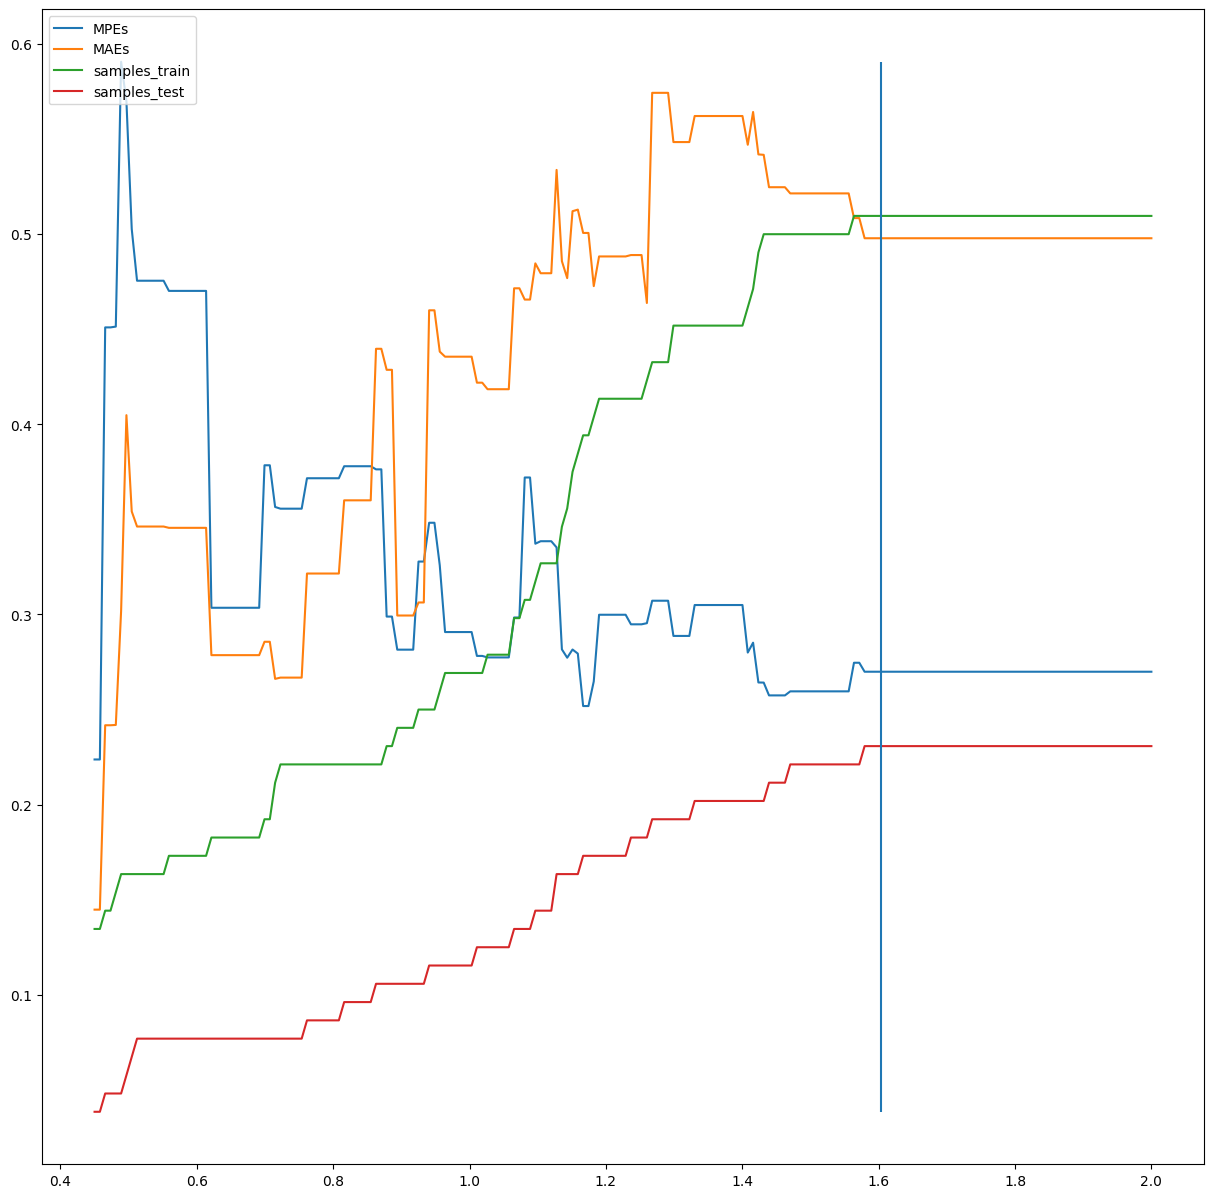

In [264]:
threads = [1, 2, 4]

ths = np.linspace(start=0.45, stop=2, num=200)
mpes = []
maes = []
samples_train = []
samples_test = []
models = []
for nprs_mean_th in tqdm(ths):
    X_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][X_keys].to_numpy()
    y_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][y_key].to_numpy()

    X_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][X_keys].to_numpy()
    y_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= nprs_mean_th].loc[df['threads'].isin(threads)][y_key].to_numpy()

    # print(X_train.shape)
    # print(X_test.shape)

    model_cross = LinearRegression()
    model_cross.fit(X=X_train, y=y_train)

    models.append(model_cross)

    y_pred = model_cross.predict(X_test)

    mpes.append(np.mean(np.abs((y_pred - y_test) / y_test)))
    maes.append(np.mean(np.abs((y_pred - y_test))))
    samples_train.append((X_train.shape[0]) / df_main.shape[0])
    samples_test.append((X_test.shape[0]) / df_main.shape[0])

    # print('MPE:', np.mean(np.abs((y_pred - y_test) / y_test)))
    # print('MAE:', np.mean(np.abs((y_pred - y_test))))

n = np.argmin(np.array(mpes)[ths >= 1.6]) + np.sum((ths < 1.6))
x = ths[n]

print('nprs_mean_th:', x)
print('MPE:', mpes[n])
print('train:', samples_train[n])
print('test:', samples_test[n])
print('train + test:', samples_train[n] + samples_test[n])

plt.figure(figsize=(15, 15))
plt.plot(ths, mpes, label='MPEs')
plt.plot(ths, maes, label='MAEs')
plt.plot(ths, samples_train, label='samples_train')
plt.plot(ths, samples_test, label='samples_test')
plt.legend(loc="upper left")
plt.vlines(x=x, ymin=np.amin([mpes, maes, samples_train, samples_test]), ymax=np.amax([mpes, maes, samples_train, samples_test]))

plt.show()


In [265]:
# Sample dataframe based on the image provided
simple_df = df[df['graph_type'] == 'simple']

# Separate into two dataframes based on the algo value
depth_df = simple_df[simple_df['algo'] == 'depth']
stock_df = simple_df[simple_df['algo'] == 'stock']

# Filter both dataframes to only include rows where nprs_mean <= 2
depth_df = depth_df[depth_df['nprs_mean'] <= 2]
stock_df = stock_df[stock_df['nprs_mean'] <= 2]

# Merge the two dataframes on graph_width and threads
merged_df = pd.merge(depth_df, stock_df, on=['graph_width', 'threads'], suffixes=('_depth', '_stock'))

# Extract the final depth and stock dataframes

final_depth_df = merged_df[['graph_width', 'threads'] + [(key + '_depth') for key in (help_keys + X_keys + [y_key]) if key not in ['graph_width', 'threads']]]
final_stock_df = merged_df[['graph_width', 'threads'] + [(key + '_stock') for key in (help_keys + X_keys + [y_key]) if key not in ['graph_width', 'threads']]]

# Rename columns for clarity
final_depth_df.columns = [(key[:-6] if key[-6:] == '_depth' else key) for key in final_depth_df.columns]
final_stock_df.columns = [(key[:-6] if key[-6:] == '_stock' else key) for key in final_depth_df.columns]

# Display the final dataframes
final_depth_df, final_stock_df

print(merged_df.shape)
print(final_depth_df.shape)
print(final_stock_df.shape)

(24, 24)
(24, 13)
(24, 13)


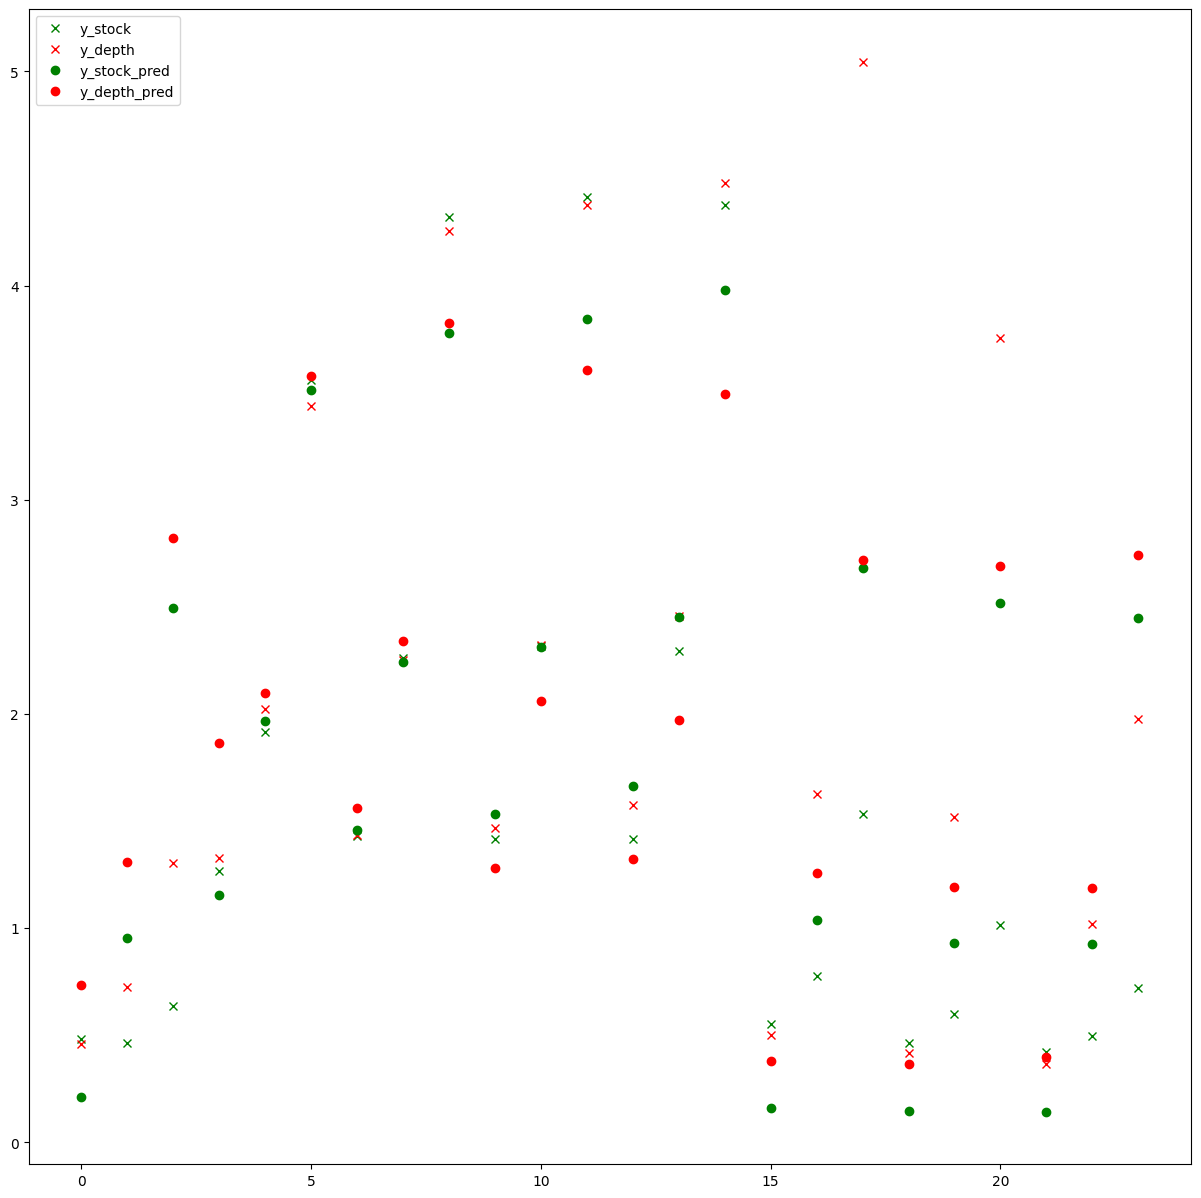

In [266]:
X_stock = final_stock_df.loc[(final_stock_df['algo'] == 'stock') & (final_stock_df['graph_type'] == 'simple')].loc[final_stock_df['nprs_mean'] <= nprs_mean_th].loc[final_stock_df['threads'].isin(threads)][X_keys].to_numpy()
y_stock = final_stock_df.loc[(final_stock_df['algo'] == 'stock') & (final_stock_df['graph_type'] == 'simple')].loc[final_stock_df['nprs_mean'] <= nprs_mean_th].loc[final_stock_df['threads'].isin(threads)][y_key].to_numpy()
X_depth = final_depth_df.loc[(final_depth_df['algo'] == 'depth') & (final_depth_df['graph_type'] == 'simple')].loc[final_depth_df['nprs_mean'] <= nprs_mean_th].loc[final_depth_df['threads'].isin(threads)][X_keys].to_numpy()
y_depth = final_depth_df.loc[(final_depth_df['algo'] == 'depth') & (final_depth_df['graph_type'] == 'simple')].loc[final_depth_df['nprs_mean'] <= nprs_mean_th].loc[final_depth_df['threads'].isin(threads)][y_key].to_numpy()

model = models[n]

y_stock_pred = model_cross.predict(X_stock)
y_depth_pred = model_cross.predict(X_depth)

xs = list(range(len(y_stock)))
plt.figure(figsize=(15, 15))
plt.plot(xs, y_stock, 'gx', label='y_stock')
plt.plot(xs, y_depth, 'rx', label='y_depth')
plt.plot(xs, y_stock_pred, 'go', label='y_stock_pred')
plt.plot(xs, y_depth_pred, 'ro', label='y_depth_pred')
plt.legend(loc="upper left")

plt.show()


In [267]:
print(df.shape)
df = df.loc[df['nprs_mean'] < x]
print(df.shape)

(104, 13)
(77, 13)


/tmp/ipykernel_6080/3822515570.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


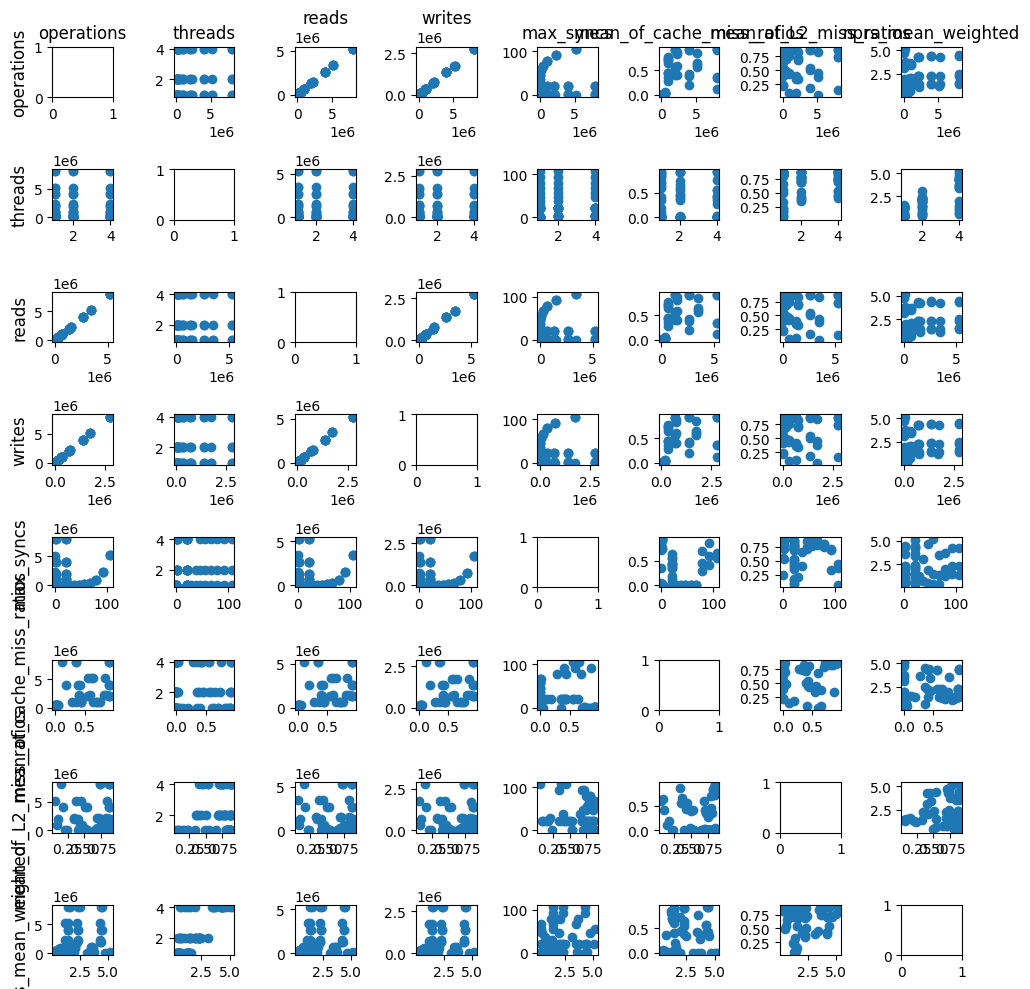

In [268]:
fig, axes = plt.subplots(len(Xy_keys), len(Xy_keys), figsize=(len(Xy_keys) * 1.25, len(Xy_keys) * 1.25))

for i in range(len(Xy_keys)):
    for j in range(len(Xy_keys)):
        if i == j:
            continue
        # i_ = i - 1 if i > j else i
        # j_ = j - 1 if j > i else j

        key1 = Xy_keys[i]
        key2 = Xy_keys[j]

        df.plot(x=key1, y=key2, style='o', ax=axes[i, j], xlabel=None, ylabel=None)
        axes[i, j].get_legend().remove()
        axes[i, j].set_ylabel(None)
        axes[i, j].set_xlabel(None)

for ax, col in zip(axes[0], Xy_keys):
    ax.set_title(col)

for ax, row in zip(axes[:, 0], Xy_keys):
    ax.set_ylabel(row, size='large')

fig.tight_layout()
fig.show()

In [269]:
# X_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][X_keys].to_numpy()
# y_train = df.loc[((df['algo'] == 'stock') & (df['graph_type'] == 'simple')) | (df['graph_type'] == 'bitonic')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][y_key].to_numpy()

# X_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][X_keys].to_numpy()
# y_test = df.loc[(df['algo'] == 'depth') & (df['graph_type'] == 'simple')].loc[df['nprs_mean'] <= 1.3].loc[df['threads'].isin(threads)][y_key].to_numpy()

# print(X_train.shape)
# print(X_test.shape)

In [270]:
df[Xy_keys].corr()

,operations,threads,reads,writes,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean_weighted
operations,1.000000,0.050771,0.999975,0.999908,0.055374,0.616864,-0.172398,0.336980
threads,0.050771,1.000000,0.050147,0.051962,0.094208,0.019323,0.136777,0.752362
reads,0.999975,0.050147,1.000000,0.999787,0.059172,0.617877,-0.173573,0.336705
writes,0.999908,0.051962,0.999787,1.000000,0.048081,0.614834,-0.170120,0.337460
max_syncs,0.055374,0.094208,0.059172,0.048081,1.000000,0.015800,-0.285933,0.257728
mean_of_cache_miss_ratios,0.616864,0.019323,0.617877,0.614834,0.015800,1.000000,-0.020962,0.341468
mean_of_L2_miss_ratios,-0.172398,0.136777,-0.173573,-0.170120,-0.285933,-0.020962,1.000000,-0.068092
nprs_mean_weighted,0.336980,0.752362,0.336705,0.337460,0.257728,0.341468,-0.068092,1.000000


In [271]:
model_smf = smf.ols(formula=y_key + ' ~ ' + ' + '.join(X_keys), data=df).fit()
print(model_smf.summary())

                            OLS Regression Results                            
Dep. Variable:     nprs_mean_weighted   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     34.12
Date:                Fri, 24 May 2024   Prob (F-statistic):           6.23e-19
Time:                        15:07:19   Log-Likelihood:                -81.599
No. Observations:                  77   AIC:                             177.2
Df Residuals:                      70   BIC:                             193.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [272]:
X = df[X_keys].to_numpy()
y = df[[y_key]].to_numpy()

In [273]:
model_lr = LinearRegression()
model_lr.fit(X=X, y=y)

y_pred = model_lr.predict(X)

print('MPE:', np.mean(np.abs((y_pred - y) / y)))
print('MAE:', np.mean(np.abs(y_pred - y)))
print(model_lr.coef_, model_lr.intercept_)

MPE: 0.41124000248536596
MAE: 0.4702647836817188
[[ 2.19412569e-06  8.03822101e-01 -9.19179469e-06  1.13862589e-05
   1.08397374e-02  1.13746005e+00 -6.29004868e-01]] [-0.12463291]


/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.23646e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.04287e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


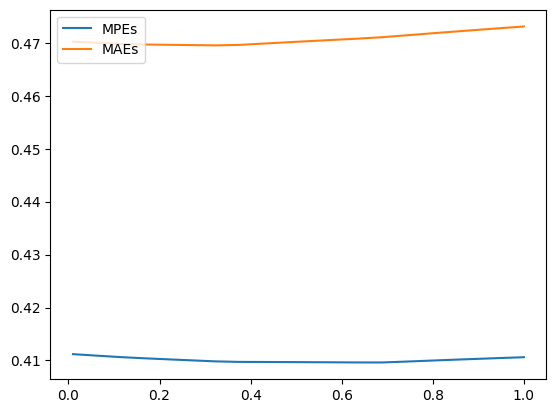

In [274]:
alphas = np.linspace(start=0.01, stop=1, num=20)
mpes = []
maes = []

for alpha in alphas:
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(X=X, y=y)

    y_pred = model_ridge.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()


/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e+01, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.670e+01, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

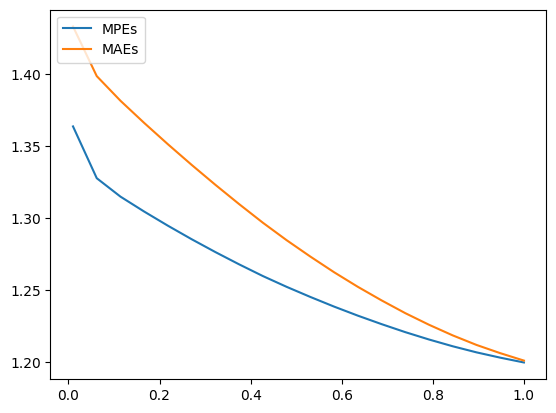

In [275]:
alphas = np.linspace(start=0.01, stop=1, num=20)
mpes = []
maes = []
for alpha in alphas:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X=X, y=y)

    y_pred = model_lasso.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()

In [276]:
mpes = []
maes = []

for _ in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.5)

    if len(mpes) == 0:
        print('train size:', len(X_train))
        print('test size:', len(X_test))

    model_lr_mlway = LinearRegression()
    model_lr_mlway.fit(X=X_train, y=y_train)

    y_pred = model_lr_mlway.predict(X_test)

    mpes.append(np.mean(np.abs((y_pred - y_test) / y_test)))
    maes.append(np.mean(np.abs((y_pred - y_test))))

print('Mean MPE:', np.mean(mpes))
print('Mean MAE:', np.mean(maes))

 13%|█▎        | 132/1000 [00:00<00:00, 1317.05it/s]

train size: 38
test size: 39


100%|██████████| 1000/1000 [00:00<00:00, 1186.53it/s]

Mean MPE: 0.4890026569911991
Mean MAE: 0.5717297544432718
